### Setup

In [1]:
# IMPORTS & OTHER SETTINGS
%run 'settings.py'
%matplotlib inline
!pwd

from scipy.spatial import distance
from sklearn.preprocessing import QuantileTransformer

/home/Dave/Notebooks


In [2]:
# File paths
data_path = '../data/'
pickle_path = os.path.join(data_path, 'pickles')
if not os.path.exists(data_path):
    raise Exception('Hold your horses, partner, you need data!')

    
# Trained LSI models
tf_lsi_path = os.path.join(pickle_path, 'tf_lsi.pkl')
cv_lsi_path = os.path.join(pickle_path, 'cv_lsi.pkl')

# Corpora
tfidf_corpus_path = os.path.join(pickle_path, 'tfidf_corpus.pkl')
tfidf_corpus = pickle.load(open(tfidf_corpus_path, 'rb'))
cv_corpus_path = os.path.join(pickle_path, 'cv_corpus.pkl')
cv_corpus = pickle.load(open(cv_corpus_path, 'rb'))

if not os.path.exists(tf_lsi_path):
    # Main text
    id2word_tf_path = os.path.join(pickle_path, 'id2word_tf.pkl')
    id2word_tf = pickle.load(open(id2word_tf_path, 'rb'))

    # Secondary text
    id2word_path = os.path.join(pickle_path, 'id2word.pkl')
    id2word = pickle.load(open(id2word_path, 'rb'))
    trained = False

if os.path.exists(tf_lsi_path):
    tf_lsi = pickle.load(open(tf_lsi_path, 'rb'))
    cv_lsi = pickle.load(open(cv_lsi_path, 'rb'))
    trained = True
    
    
# Main df
no318_listings = os.path.join(data_path, 'neworleans/listings.csv')
sf318_listings = os.path.join(data_path, 'sanfrancisco/listings.csv')
pd218_listings = os.path.join(data_path, 'portland/listings.csv')
sy118_listings = os.path.join(data_path, 'sydney/listings.csv')
ny318_listings = os.path.join(data_path, 'newyork/listings.csv')
    
def get_data(cities):
    ''' Concatenate the listings into one dataframe '''
    dfs = []
    for city in cities:
        dfs.append(pd.read_csv(city, infer_datetime_format=True,
                               parse_dates = 
                               ['last_scraped', 'host_since', 'calendar_last_scraped',
                                'first_review', 'last_review']))
    return pd.concat(dfs)

cities = [no318_listings, sf318_listings, pd218_listings, sy118_listings, ny318_listings]

df = get_data(cities).reset_index(drop=True).reset_index()

### Last Minute Cleaning

In [3]:
def clean_price(x):
    y = x.split('.')[0] \
         .replace('$', '') \
         .replace(',', '') 
    return y

def replace_tf(x):
    x = x.replace('t', '1')
    y = x.replace('f', '0')
    return y

# Clean columns
df['price'] = df.price.apply(clean_price).astype('uint8')
df['instant_bookable'] = df.instant_bookable.apply(replace_tf).astype('uint8')
df['is_business_travel_ready'] = df.is_business_travel_ready.apply(replace_tf).astype('uint8')

### Training LSI Model for Engineered Text Features

In [4]:
%%time

# Fitting LSI models
if not trained:
    num = 2**9
    cv_lsi = models.LsiModel(corpus=cv_corpus, id2word=id2word, num_topics=num,
                             power_iters=3, extra_samples=250)

    tf_lsi = models.LsiModel(corpus=tfidf_corpus, id2word=id2word_tf, num_topics=num,
                             power_iters=3, extra_samples=250)
    pickle.dump(cv_lsi, open(cv_lsi_path, 'wb'))
    pickle.dump(tf_lsi, open(tf_lsi_path, 'wb'))

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.39 µs


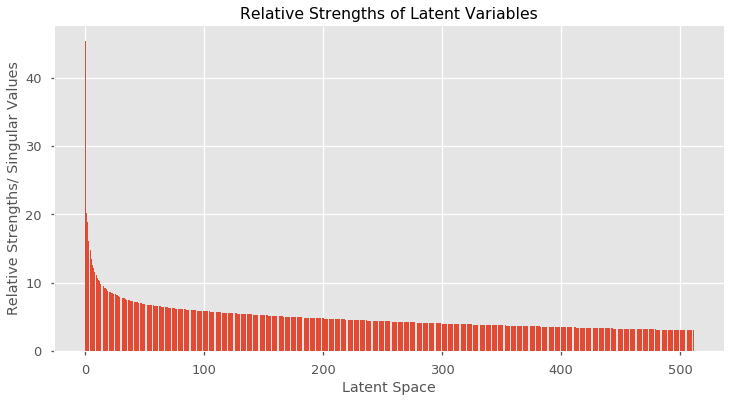

In [6]:
# Plotting the singular values received from SVD/ LSI
plt.figure(figsize=(12,6))
plt.bar(range(len(tf_lsi.projection.s)), tf_lsi.projection.s)
plt.xlabel('Latent Space')
plt.ylabel('Relative Strengths/ Singular Values')
plt.title('Relative Strengths of Latent Variables');

In [7]:
%%time
num = 2**9

# Retrieve vectors for the original corpus in the LS space ("transform" in sklearn)
lsi_tfidf_corpus = tf_lsi[tfidf_corpus]
lsi_cv_corpus = cv_lsi[cv_corpus]

# Dump the resulting document vectors into a list
doc_tfidf_vecs = [doc for doc in lsi_tfidf_corpus]
doc_cv_vecs = [doc for doc in lsi_cv_corpus]

# Create an index transformer that calculates similarity based on our space
indx = similarities.MatrixSimilarity(doc_tfidf_vecs, num_features=num)
indx2 = similarities.MatrixSimilarity(doc_cv_vecs, num_features=num)

CPU times: user 1min 49s, sys: 8.52 s, total: 1min 58s
Wall time: 1min 58s


### Functions Used by Recommender

In [8]:
def haversine(lat1, lon1, lat2, lon2, R=3963.1905919):
    ''' 
    Finds the distance of 2 latitudes and longitudes 
    R is the Earth's radius in miles 
    '''
    
    dLat = radians(lat2 - lat1)
    dLon = radians(lon2 - lon1)
    lat1 = radians(lat1)
    lat2 = radians(lat2)

    a = sin(dLat/2)**2 + cos(lat1)*cos(lat2)*sin(dLon/2)**2
    c = 2*asin(sqrt(a))
    return R * c

def calc_distances(rec_df):
    ''' Applies the haversine formula to the recommendation dataframe '''
    
    loc_cols = ['latitude', 'longitude']
    lat1 = rec_df.latitude.loc[0]
    lon1 = rec_df.longitude.loc[0]
    rec_df['loc_dist'] = rec_df[loc_cols].apply(lambda x: 
        haversine(lat1, lon1, x.latitude, x.longitude), axis=1)
    
    return rec_df
    

def get_info(df, sims, reach=1000):
    ''' Combines the top similar listings with the main data '''
    columns = \
    [    
        'index','id','name','host_name','host_is_superhost', 
        'neighbourhood_cleansed','latitude','longitude','property_type',
        'room_type','accommodates','beds','price','minimum_nights',
        'maximum_nights','has_availability','instant_bookable',
        'is_business_travel_ready'
    ]
    
    df = df[columns] 
    columns = ['index','similarity'] # index = position in original dataframe
    top_df = pd.DataFrame(sims[:reach], columns=columns)
    return pd.merge(top_df, df, how='left', on='index')
    
def merge_other(rec_df, df, sims):
    ''' Combines the other similarity scores with the main recommender df'''
    columns = ['index', 'similarity']
    secondary_df = pd.DataFrame(sims, columns=columns)
    return pd.merge(rec_df, secondary_df)

### The Meat

In [87]:
def recommendation(listing, indx, indx2, doc_tfidf_vecs, doc_cv_vecs, df, n_return=15):
    ''' 
    Takes a listing ID and the dataframe of listing information 
    to compute the top 15 similar listings
    '''

    # Get the listing position for the similarity matrix
    listing = list(df.id).index(listing)

    
    # Return the sorted list of cosine similarities to the listing document
    sims = sorted(enumerate(indx[doc_tfidf_vecs[listing]]), 
                            key=lambda item: -item[1])
    sims2 = sorted(enumerate(indx2[doc_cv_vecs[listing]]),
                            key=lambda item: -item[1])
    

    # Assemble data and calculate location distances
    rec_df = get_info(df, sims)
    secondary_df = get_info(df, sims2, reach=100000)
    rec_df = pd.merge(rec_df, secondary_df.iloc[:,1:3], how='left', on='id', suffixes=('', '_2'))
    
    rec_df = calc_distances(rec_df)
    
    
    # Buffer on guests accommodated and nights available
    guests = rec_df.accommodates.loc[0] - 3
    min_ni = rec_df.minimum_nights.loc[0] - 3
    max_ni = rec_df.maximum_nights.loc[0] + 3
    

    # Applying buffers/ filters on data
    rec_df = rec_df[(rec_df.accommodates   >= guests)]
    rec_df = rec_df[(rec_df.minimum_nights >= min_ni)]
    rec_df = rec_df[(rec_df.maximum_nights <= max_ni)]
    rec_df = rec_df[(rec_df.has_availability == 't')]
            

    # Maintain positioning information
    index_id_map = rec_df[['index', 'id']] # index = position in main dataframe
    

    # Grab & clean columns for 'distance' comparison
    columns = ['similarity', 'similarity_2', 'loc_dist', 'accommodates', 'beds',
               'price', 'is_business_travel_ready', 'instant_bookable'
              ]
    rec_df = rec_df[columns]
    rec_df.beds.fillna(0, inplace=True)
    

    # Using a robust quantile transformer for the similarity calculation
    qt = QuantileTransformer(random_state=42, output_distribution='uniform')
    rec_df = qt.fit_transform(rec_df)
    
    
    # User decides the weights!
    # Listing description (w)
    try:
        desc_score = input('Are you interested in finding a similar ' +
                           'listing based on the description? (Y/N)\t')
        if 'y' in desc_score.lower():
            desc_score = 1.5
        elif 'n' in desc_score.lower():
            desc_score = 0.5
        else:
            raise Exception
    except:
        raise ValueError("I'm looking for some kind of yes or no answer.")
        

    # Host description (w)
    try:
        host_score = input('Are you interested in finding a similar ' +
                           'listing based on this host? (Y/N)\t')
        if 'y' in host_score.lower():
            host_score = 1.5
        elif 'n' in host_score.lower():
            host_score = 0.5
        else:
            raise Exception
    except:
        raise ValueError("I'm looking for some kind of yes or no answer.")
        
   
    # Business trip (w)
    try:
        business_score = input('Is this a business trip? (Y/N)\t')
        if 'y' in business_score.lower():
            business_score = 1.5
        elif 'n' in business_score.lower():
            business_score = 0.2
        else:
            raise Exception
    except:
        raise ValueError("I'm looking for some kind of yes or no answer.")
    
    # Price weighting
    try:
        price_score = \
            int(input('How important is the price? Rate [1-5]\n' +
                      "1 means you can explore other prices.\n" +
                      '5 means you found the price you want!\t'))
        if price_score < 1 or price_score > 5:
            raise Exception
        price_score /= 3
    except:
        raise ValueError('Please score this on a scale from 1 to 5!')

    # Location weighting
    try:
        dist_score = \
            int(input('How important is the location? Rate [1-5]\n' +
                      '1 means you are open to other neighborhoods\n' +
                      '5 means you want to stay close!\t'))
        if 1 >= dist_score >= 5:
            raise ValueError('Please score this on a scale form 1 to 5!')
        dist_score /= 1
    except:
        raise ValueError("That's an incorrect input!")
    
    columns = ['similarity', 'similarity_2', 'loc_dist', 'accommodates', 'beds',
               'price', 'is_business_travel_ready', 'instant_bookable']
    
    # Dampen control variables
    bed_score = .25
    accomodates_score = .5
    book_score = .25

    # Dynamic columns for rescoring
    desc_similarity = columns.index('similarity')
    host_similarity = columns.index('similarity_2')
    business = columns.index('is_business_travel_ready')
    pricing = columns.index('price')
    location = columns.index('loc_dist')
    beds = columns.index('beds')
    accommodation = columns.index('accommodates')
    instant_book = columns.index('instant_bookable')

    rec_df[:, desc_similarity] = rec_df[:, desc_similarity] * desc_score
    rec_df[:, host_similarity] = rec_df[:, host_similarity] * host_score
    rec_df[:, business] = rec_df[:, business] * business_score
    rec_df[:, pricing] = rec_df[:, pricing] * price_score
    rec_df[:, location] = rec_df[:, location] * dist_score
    rec_df[:, beds] = rec_df[:, beds] * bed_score
    rec_df[:, accommodation] = rec_df[:, accommodation] * accomodates_score
    rec_df[:, instant_book] = rec_df[:, instant_book] * book_score
    print(pd.DataFrame(rec_df, columns = columns).describe())######
    
    # Calculate similarity of the related listings
    rec_df = distance.cdist(rec_df, rec_df, 'minkowski', p=2)[0]
    rec_df = pd.DataFrame(rec_df, columns=['distance'])
    rec_df = pd.concat([index_id_map.reset_index(drop=True), rec_df], 
                       axis=1, ignore_index=True)
    rec_df.rename({0:'position', 1:'id', 2:'distance'}, axis='columns', inplace=True)
    rec_df.sort_values(by='distance', inplace=True)
    return rec_df.head(n_return)

### Results

In [92]:
%%time

recommendations = recommendation(18997233, indx, indx2, doc_tfidf_vecs, doc_cv_vecs, df)

Are you interested in finding a similar listing based on the description? (Y/N)	y
Are you interested in finding a similar listing based on this host? (Y/N)	n
Is this a business trip? (Y/N)	n
How important is the price? Rate [1-5]
1 means you can explore other prices.
5 means you found the price you want!	1
How important is the location? Rate [1-5]
1 means you are open to other neighborhoods
5 means you want to stay close!	5
       similarity  similarity_2   loc_dist  accommodates       beds  \
count  29.0000000    29.0000000 29.0000000    29.0000000 29.0000000   
mean    0.7499496     0.2500032  2.4999982     0.2437783  0.0474095   
std     0.4561007     0.1520235  1.5204715     0.1427417  0.0947118   
min     0.0000001     0.0000000  0.0000005     0.0000000  0.0000000   
25%     0.3752166     0.1250867  1.2489567     0.2409910  0.0000000   
50%     0.7499678     0.2498046  2.4977447     0.2409910  0.0000000   
75%     1.1261059     0.3748879  3.7497145     0.2409910  0.0000000   
max 

In [93]:
recommendations.sort_values('id')

,position,id,distance
26,48852,380416,1.6129535
11,48968,437352,0.7533954
3,52634,2273613,0.6512230
8,53185,2716929,2.2406539
1,54475,3701708,1.9977585
2,55056,4054332,1.6245847
25,57906,5693879,2.2621746
4,63378,8931635,1.5113781
6,66339,10166820,0.5149982
16,68852,12302429,1.2911418


In [94]:
%%time

recommendations2 = recommendation(18997233, indx, indx2, doc_tfidf_vecs, doc_cv_vecs, df)

Are you interested in finding a similar listing based on the description? (Y/N)	y
Are you interested in finding a similar listing based on this host? (Y/N)	n
Is this a business trip? (Y/N)	n
How important is the price? Rate [1-5]
1 means you can explore other prices.
5 means you found the price you want!	5
How important is the location? Rate [1-5]
1 means you are open to other neighborhoods
5 means you want to stay close!	1
       similarity  similarity_2   loc_dist  accommodates       beds  \
count  29.0000000    29.0000000 29.0000000    29.0000000 29.0000000   
mean    0.7499496     0.2500032  0.4999996     0.2437783  0.0474095   
std     0.4561007     0.1520235  0.3040943     0.1427417  0.0947118   
min     0.0000001     0.0000000  0.0000001     0.0000000  0.0000000   
25%     0.3752166     0.1250867  0.2497913     0.2409910  0.0000000   
50%     0.7499678     0.2498046  0.4995489     0.2409910  0.0000000   
75%     1.1261059     0.3748879  0.7499429     0.2409910  0.0000000   
max 

In [95]:
recommendations2.sort_values('id')

,position,id,distance
11,48968,437352,0.8864701
3,52634,2273613,0.9029962
8,53185,2716929,1.3810711
1,54475,3701708,0.5716728
2,55056,4054332,0.8072060
10,55780,4439664,1.3789937
7,59464,6705413,1.1146076
6,66339,10166820,0.4920216
9,68562,12086351,0.9357993
16,68852,12302429,1.2899227
